In [1]:
import numpy as np
import glob
import os 
import xarray as xr 
from datetime import datetime, timedelta
import seaborn as sb
import matplotlib.pyplot as plt 
import matplotlib as mpl
import matplotlib.patches as patches
%config InlineBackend.figure_format = 'retina'
import cartopy.crs as ccrs
import matplotlib.cm as cm
from dask.diagnostics import ProgressBar
from cart_plot import cart_plot
from tqdm import tqdm

### LOAD TEMPEST MPAS DATA FOR CTRL

In [2]:
# Path to the directory where the storm track data is stored
mpath = '/glade/work/ktquagra/MAAG_project/datasets/TE_data_MPAS/'

# Open the track file for the specified date range (Sept 15–31, 2017)
with open(f'{mpath}SN_test_2017_09_15_31.txt', 'r') as f:
    lines = f.readlines()

# Dictionary to store parsed tracks
_store_tracks = {}
count = 0  # Track counter

# Iterate through each line (except the last) to process tracks
for i in tqdm(range(len(lines) - 1), desc="Processing", unit="line"):
    
    line = lines[i]  # Read current line
    linesplit = line.strip().split('\t')  # Split by tab to isolate elements

    # If the line indicates the start of a new track
    if linesplit[0] == 'start': 
        
        # Get the number of lines that belong to this track
        tracklength = int(linesplit[1])

        # Read the next `tracklength` lines as a NumPy array
        trackarray = np.genfromtxt(lines[i + 1:i + 1 + tracklength])

        # Convert longitudes from 0–360 to -180–180 (if necessary)
        trackarray[:, 2] = (trackarray[:, 2] + 180) % 360 - 180

        # Store the track in the dictionary with a unique key
        _store_tracks[f'track_{count}'] = trackarray

        # Increment the track counter
        count += 1

Processing: 100%|██████████| 214/214 [00:00<00:00, 79474.15line/s]


### LOAD TEMPEST MPAS DATA FOR PGW

In [3]:
# Path to the directory where the storm track data is stored
mpath = '/glade/work/ktquagra/MAAG_project/datasets/TE_data_MPAS/'

# Open the track file for the specified date range (Sept 15–31, 2017)
with open(f'{mpath}SN_test_PGW_2017_09_15_31_test4.txt', 'r') as f:
    lines = f.readlines()

# Dictionary to store parsed tracks
_store_pgw_tracks = {}
count = 0  # Track counter

# Iterate through each line (except the last) to process tracks
for i in tqdm(range(len(lines) - 1), desc="Processing", unit="line"):
    
    line = lines[i]  # Read current line
    linesplit = line.strip().split('\t')  # Split by tab to isolate elements

    # If the line indicates the start of a new track
    if linesplit[0] == 'start': 
        
        # Get the number of lines that belong to this track
        tracklength = int(linesplit[1])

        # Read the next `tracklength` lines as a NumPy array
        trackarray = np.genfromtxt(lines[i + 1:i + 1 + tracklength])

        # Convert longitudes from 0–360 to -180–180 (if necessary)
        trackarray[:, 2] = (trackarray[:, 2] + 180) % 360 - 180

        # Store the track in the dictionary with a unique key
        _store_pgw_tracks[f'track_{count}'] = trackarray

        # Increment the track counter
        count += 1

Processing: 100%|██████████| 270/270 [00:00<00:00, 203826.87line/s]


### LOAD IBTrACS DATA 

In [4]:
# Open the IBTrACS NetCDF file and convert it to a pandas DataFrame
# Resetting the index flattens the multi-index from xarray for easier manipulation
df = xr.open_dataset('../datasets/IBTrACS/IBTrACS.since1980.v04r01.nc').to_dataframe().reset_index()

# Filter the DataFrame for Hurricane Maria in the 2017 season
# 'name' is stored as a byte string (b'MARIA'), so we use the byte literal to match it
maria = df[(df['name'] == b'MARIA') & (df['season'] == 2017)]

# Drop rows where latitude or longitude is missing
maria_df = maria.dropna(subset=['lat', 'lon'])


Test Plot 

/glade/work/ktquagra/miniconda3/envs/workpy/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


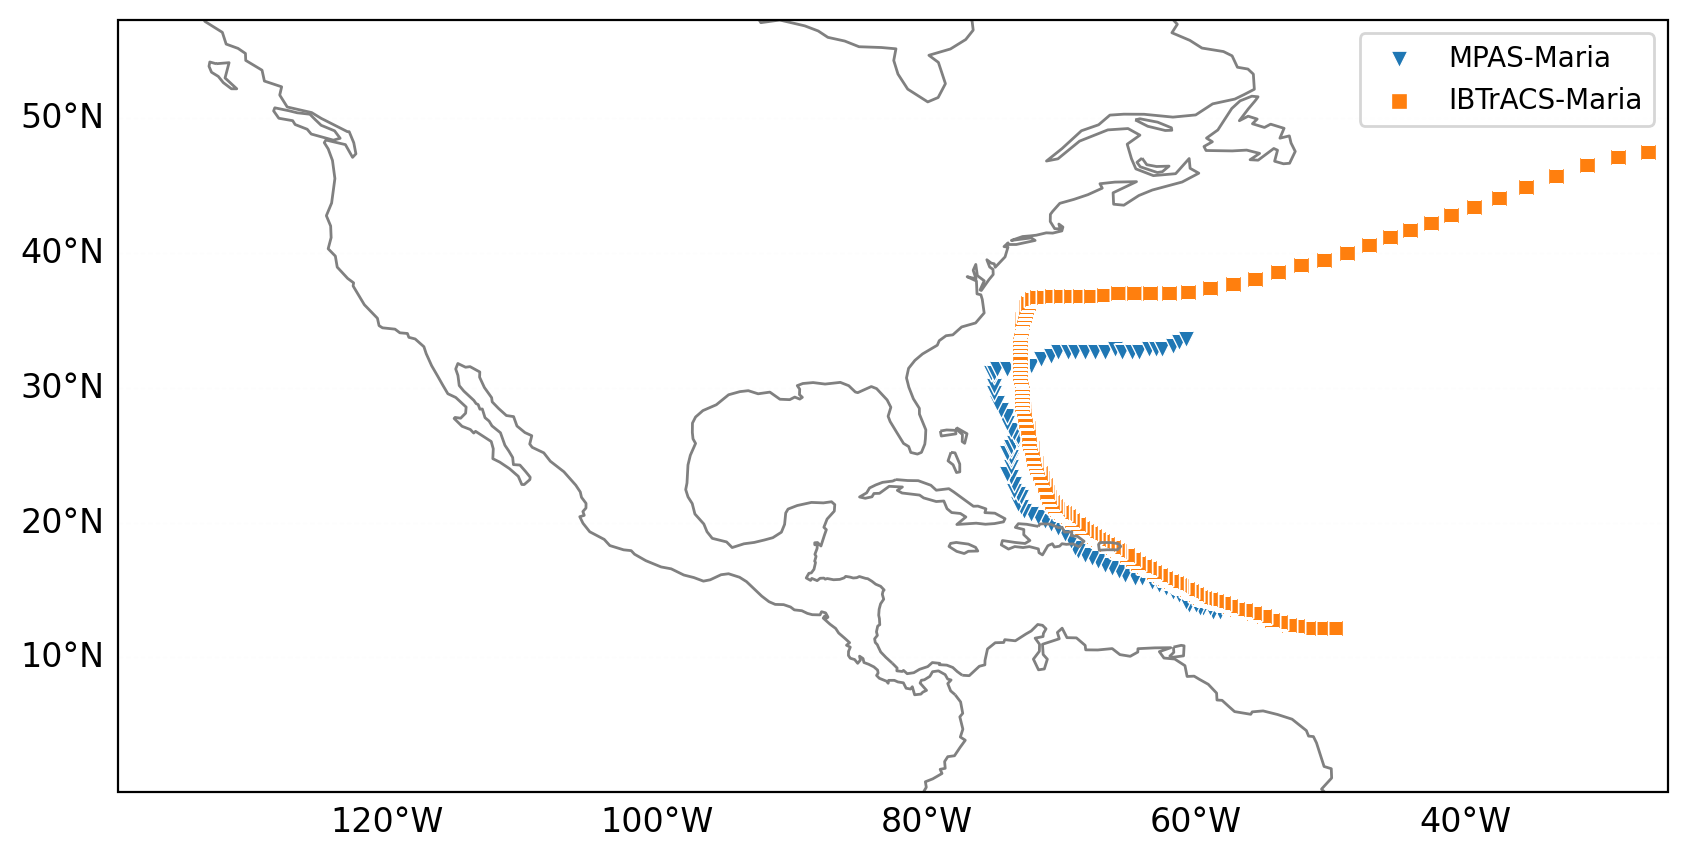

In [50]:
fig,axes = plt.subplots(ncols=1, nrows=1,figsize=(10,8),subplot_kw={'projection':ccrs.PlateCarree()})
labels=['MPAS-Maria', 'IBTrACS-Maria']
mks=['v','s']
for cx,ct in enumerate([3]):
    xvals = _store_tracks[f'track_{ct}'][:][:,2]
    yvals = _store_tracks[f'track_{ct}'][:][:,3]
    sb.scatterplot(ax=axes, x= xvals,y=yvals,
                   marker=mks[0],
                   label=labels[0])

    sb.scatterplot(ax=axes, x= maria_df['lon'],y=maria_df['lat'],
                   marker=mks[1],
                   label=labels[1])
    cart_plot(axes,0,ncols=1,nrows=1,llon=-140,rlon=-25,tlat=40,blat=0)

    

### Publication Plot 

#### Obtain intersection of times for Maria in IBTrACS and MPAS

In [5]:
MPAS_time_ctrl = [np.datetime64(f'{int(ts[:][-4])}-{str(int(ts[:][-3])).zfill(2)}-{int(ts[:][-2])}T{str(int(ts[:][-1])).zfill(2)}') 
                  for ts in _store_tracks['track_3']]

MPAS_time_pgw = [np.datetime64(f'{int(ts[:][-4])}-{str(int(ts[:][-3])).zfill(2)}-{int(ts[:][-2])}T{str(int(ts[:][-1])).zfill(2)}') 
                  for ts in _store_pgw_tracks['track_3']]

In [6]:
Maria_time_ibtracs = [np.datetime64(mt,'h') for mt in maria_df['time'].values]

In [7]:
intersect_mpas = np.intersect1d(MPAS_time_ctrl,Maria_time_ibtracs)

In [8]:
_intersection_index = [Maria_time_ibtracs.index(ints) for ints in intersect_mpas]

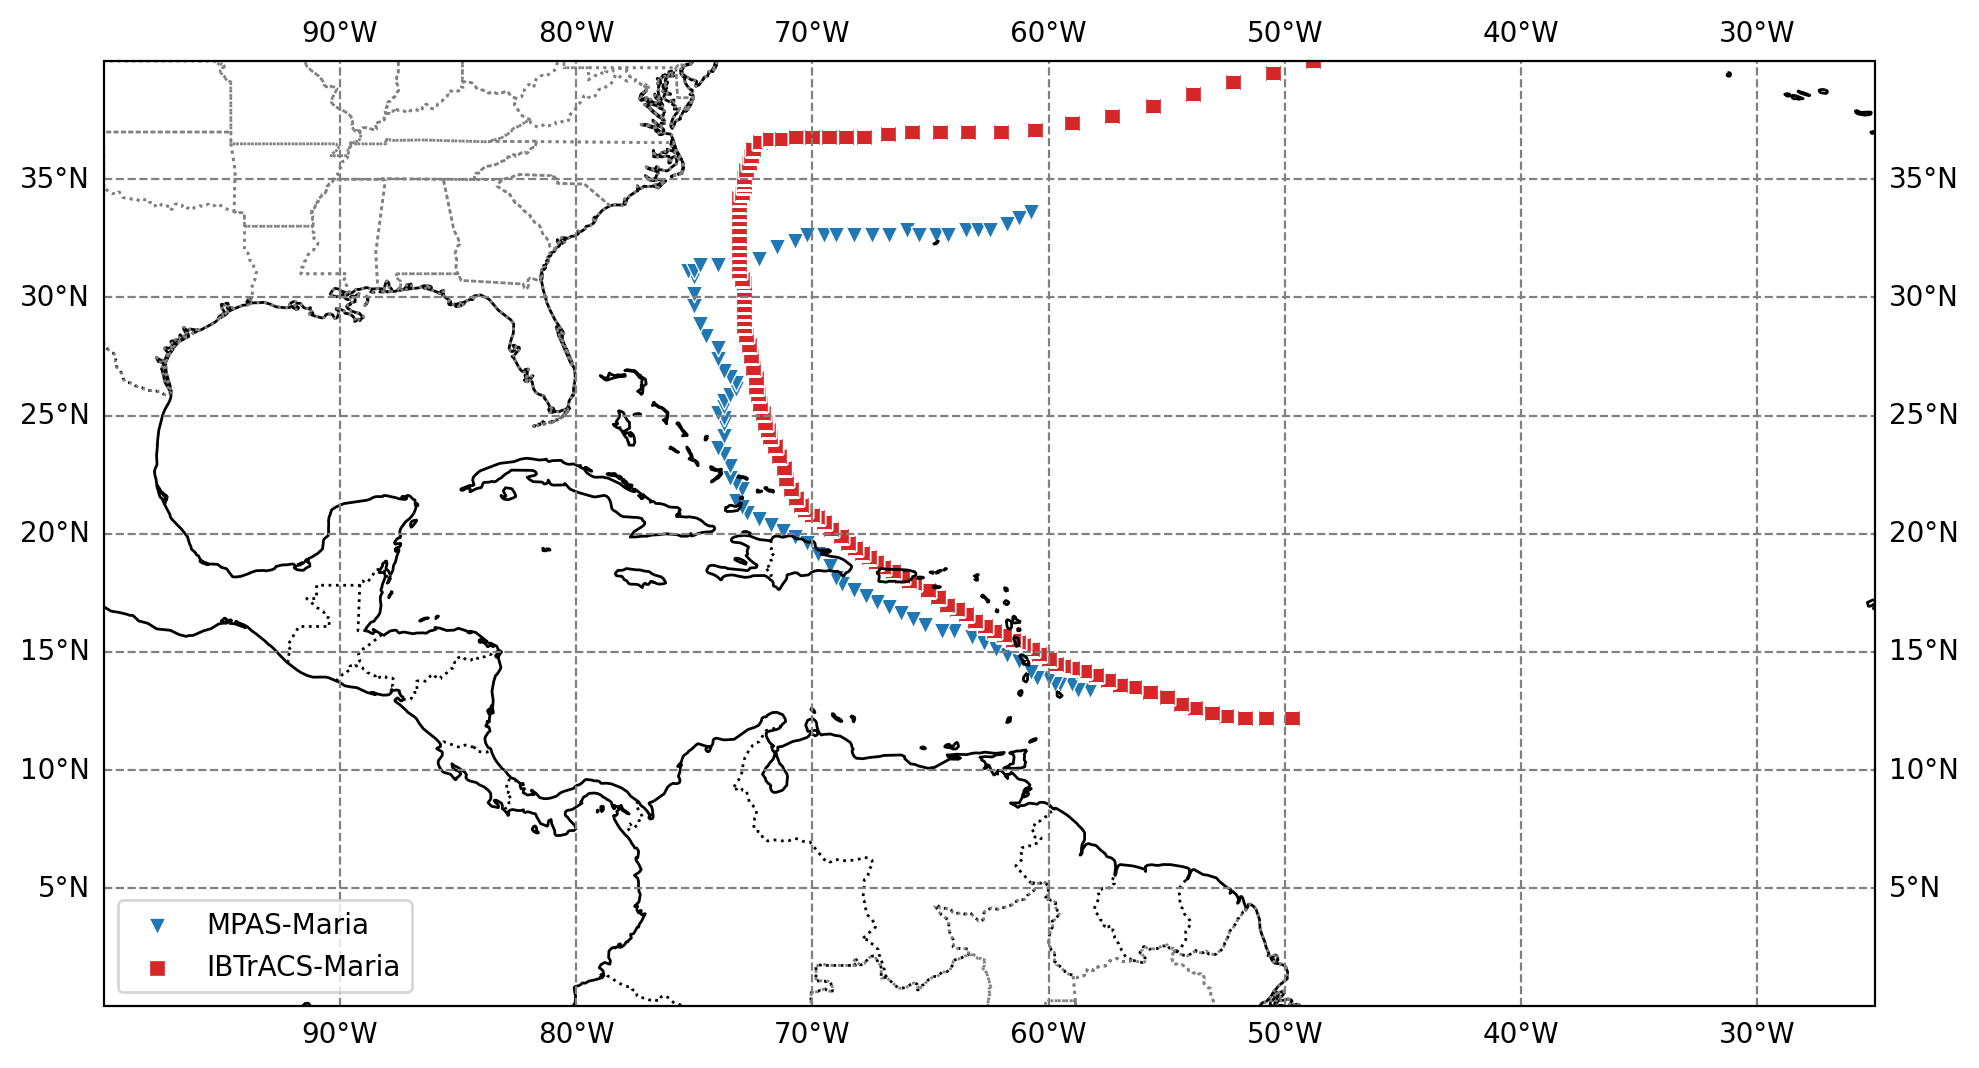

In [127]:
import matplotlib.pyplot as plt
import seaborn as sb
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set up the figure and axis with a PlateCarree projection for geographic plotting
fig, axes = plt.subplots(
    ncols=1, 
    nrows=1,
    figsize=(10, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Labels and markers for legend
labels = ['MPAS-Maria', 'IBTrACS-Maria']
mks = ['v', 's']  # Marker styles

# Plot MPAS-Maria (model) and IBTrACS-Maria (observation) for one selected track
for cx, ct in enumerate([3]):
    # Extract longitude and latitude for the MPAS-Maria track
    xvals = _store_tracks[f'track_{ct}'][:, 2]
    yvals = _store_tracks[f'track_{ct}'][:, 3]

    # Plot MPAS-Maria track
    sb.scatterplot(
        ax=axes, 
        x=xvals,
        y=yvals,
        marker=mks[0],
        label=labels[0],
        color='tab:blue'
    )

    # Plot IBTrACS-Maria track
    sb.scatterplot(
        ax=axes, 
        x=maria_df['lon'], 
        y=maria_df['lat'],
        marker=mks[1],
        label=labels[1],
        color='tab:red'
    )

    # Customize the map view using Cartopy
    axes.set_extent([-100, -25, 0, 40], crs=ccrs.PlateCarree())  # [llon, rlon, blat, tlat]

    # Add geographical features for context
    axes.add_feature(cfeature.COASTLINE)
    axes.add_feature(cfeature.BORDERS, linestyle=':')
    axes.add_feature(cfeature.STATES, linestyle=':', edgecolor='gray')
    axes.gridlines(draw_labels=True, linestyle='--', color='gray')

    # Add title and legend
    # axes.set_title('Hurricane Maria Track: MPAS vs IBTrACS (2017)', fontsize=14)
    axes.legend(loc='lower left')

plt.tight_layout()
plt.savefig('../Images/Tracks_ib_ctrl.png',dpi=350)

plt.show()


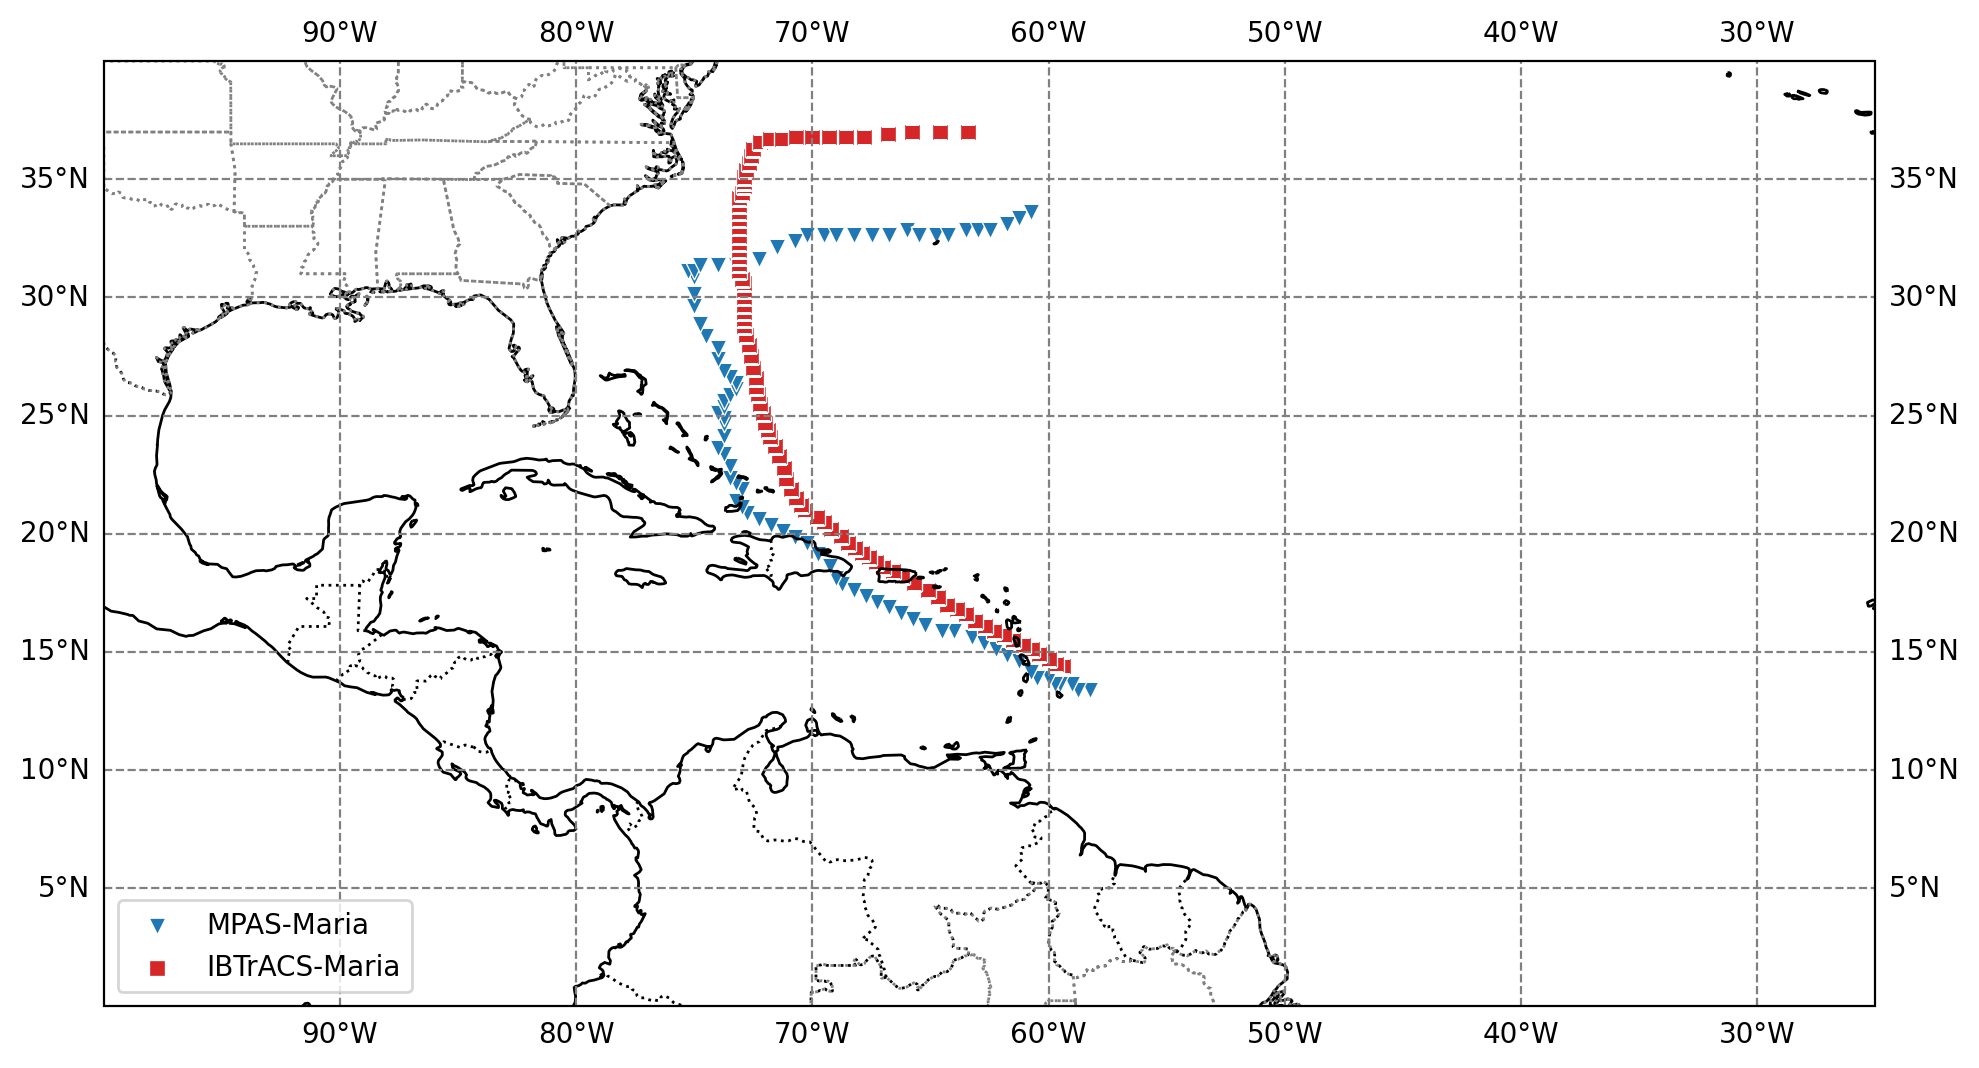

In [126]:
import matplotlib.pyplot as plt
import seaborn as sb
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set up the figure and axis with a PlateCarree projection for geographic plotting
fig, axes = plt.subplots(
    ncols=1, 
    nrows=1,
    figsize=(10, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Labels and markers for legend
labels = ['MPAS-Maria', 'IBTrACS-Maria']
mks = ['v', 's']  # Marker styles

# Plot MPAS-Maria (model) and IBTrACS-Maria (observation) for one selected track
for cx, ct in enumerate([3]):
    # Extract longitude and latitude for the MPAS-Maria track
    xvals = _store_tracks[f'track_{ct}'][:, 2]
    yvals = _store_tracks[f'track_{ct}'][:, 3]

    # Plot MPAS-Maria track
    sb.scatterplot(
        ax=axes, 
        x=xvals,
        y=yvals,
        marker=mks[0],
        label=labels[0],
        color='tab:blue'
    )

    # Plot IBTrACS-Maria track
    sb.scatterplot(
        ax=axes, 
        x=np.array(maria_df['lon'])[_intersection_index], 
        y=np.array(maria_df['lat'])[_intersection_index],
        marker=mks[1],
        label=labels[1],
        color='tab:red'
    )

    # Customize the map view using Cartopy
    axes.set_extent([-100, -25, 0, 40], crs=ccrs.PlateCarree())  # [llon, rlon, blat, tlat]

    # Add geographical features for context
    axes.add_feature(cfeature.COASTLINE)
    axes.add_feature(cfeature.BORDERS, linestyle=':')
    axes.add_feature(cfeature.STATES, linestyle=':', edgecolor='gray')
    axes.gridlines(draw_labels=True, linestyle='--', color='gray')

    # Add title and legend
    # axes.set_title('Hurricane Maria Track: MPAS vs IBTrACS (2017) \nIntersection of Dates', fontsize=14)
    axes.legend(loc='lower left')

plt.tight_layout()
plt.savefig('../Images/Tracks_intersection_ib_ctrl.png',dpi=350)

plt.show()


### TO-DO: MAKE PLOTS FOR WIND SPEED AND STORM SPEED

1. WIND SPEED:
   * Use IBTrACS' lon,lat coordinates to locate ERA5 windspeed for the storm
   * Use TempestExtreme storm location to determine the MPAS windspeed for the storm
2. STORM SPEED/ PROPAGATION
   * Use the data from the windspeed and do a diff to obtain the change in windspeeds
   * Use the lon,lat locations and do a diff to obtain the change in distance
   * Use $\frac{\Delta windspeed}{\Delta distance}$

In [9]:
### LOAD ERA5 DATA 

ERA_path = "/glade/campaign/collections/rda/data/d633000/e5.oper.an.sfc/201709/"

u_winds = xr.open_mfdataset(f'{ERA_path}*10u.*nc').assign_coords( longitude=(
            lambda ds: (ds.longitude + 180) % 360 - 180)).sortby(
            lambda ds: ds['longitude']).load()
v_winds = xr.open_mfdataset(f'{ERA_path}*10v.*nc').assign_coords( longitude=(
            lambda ds: (ds.longitude + 180) % 360 - 180)).sortby(
            lambda ds: ds['longitude']).load()

In [10]:
era_msl = xr.open_mfdataset(f'{ERA_path}*msl.*nc').assign_coords( longitude=(
            lambda ds: (ds.longitude + 180) % 360 - 180)).sortby(
            lambda ds: ds['longitude']).load()

In [11]:
### LOAD MPAS DATA
MPAS_CTRL_path = '../mpas_ko_scripts/post_process/ter_deg.25_TEMPEST_preprocessed_data_2017_09_15-31.nc'
mpas_data = xr.open_mfdataset(MPAS_CTRL_path).assign_coords( lon=(
            lambda ds: (ds.lon + 180) % 360 - 180)).sortby(
            lambda ds: ds['lon']).load()

MPAS_PGW_path = '../mpas_ko_scripts/post_process/ter_deg.25_PGW_TEMPEST_preprocessed_data_2017_09_15-31.nc'
mpas_pgw_data = xr.open_mfdataset(MPAS_PGW_path).assign_coords( lon=(
            lambda ds: (ds.lon + 180) % 360 - 180)).sortby(
            lambda ds: ds['lon']).load()

In [12]:
## Calculate ERA5 windspeeds
era_ws = (u_winds.sel(time=intersect_mpas)['VAR_10U']**2 + v_winds.sel(time=intersect_mpas)['VAR_10V']**2).reduce(np.sqrt)


In [13]:
ct = 3 
## Obtain the lon-lats for MPAS and IBTrACS
x_mpas_ctrl = _store_tracks[f'track_{ct}'][:, 2]
y_mpas_ctrl = _store_tracks[f'track_{ct}'][:, 3]

x_ibtracs=np.array(maria_df['lon'])[_intersection_index]
y_ibtracs=np.array(maria_df['lat'])[_intersection_index]

In [14]:
rad = 0.25/2
ibtracs_ws = [era_ws.sel(time=t, latitude = slice(y+rad, y-rad)
                                , longitude=slice(x-rad,x+rad)).mean(['longitude','latitude']).values 
              for t,x,y in zip(intersect_mpas,x_ibtracs,y_ibtracs)]

In [15]:
rad = 0.25/2
mpas_ctrl_vars = [mpas_data.sel(time=t, lat = slice(y-rad, y+rad)
                                , lon=slice(x-rad,x+rad)).mean(['lon','lat']) 
                  for t,x,y in zip(intersect_mpas,x_mpas_ctrl,y_mpas_ctrl)]
mpas_ctrl_ws = [mpas_ctrl_vars[ix]['wind_speed10m'].values for ix in range(0,len(mpas_ctrl_vars))]

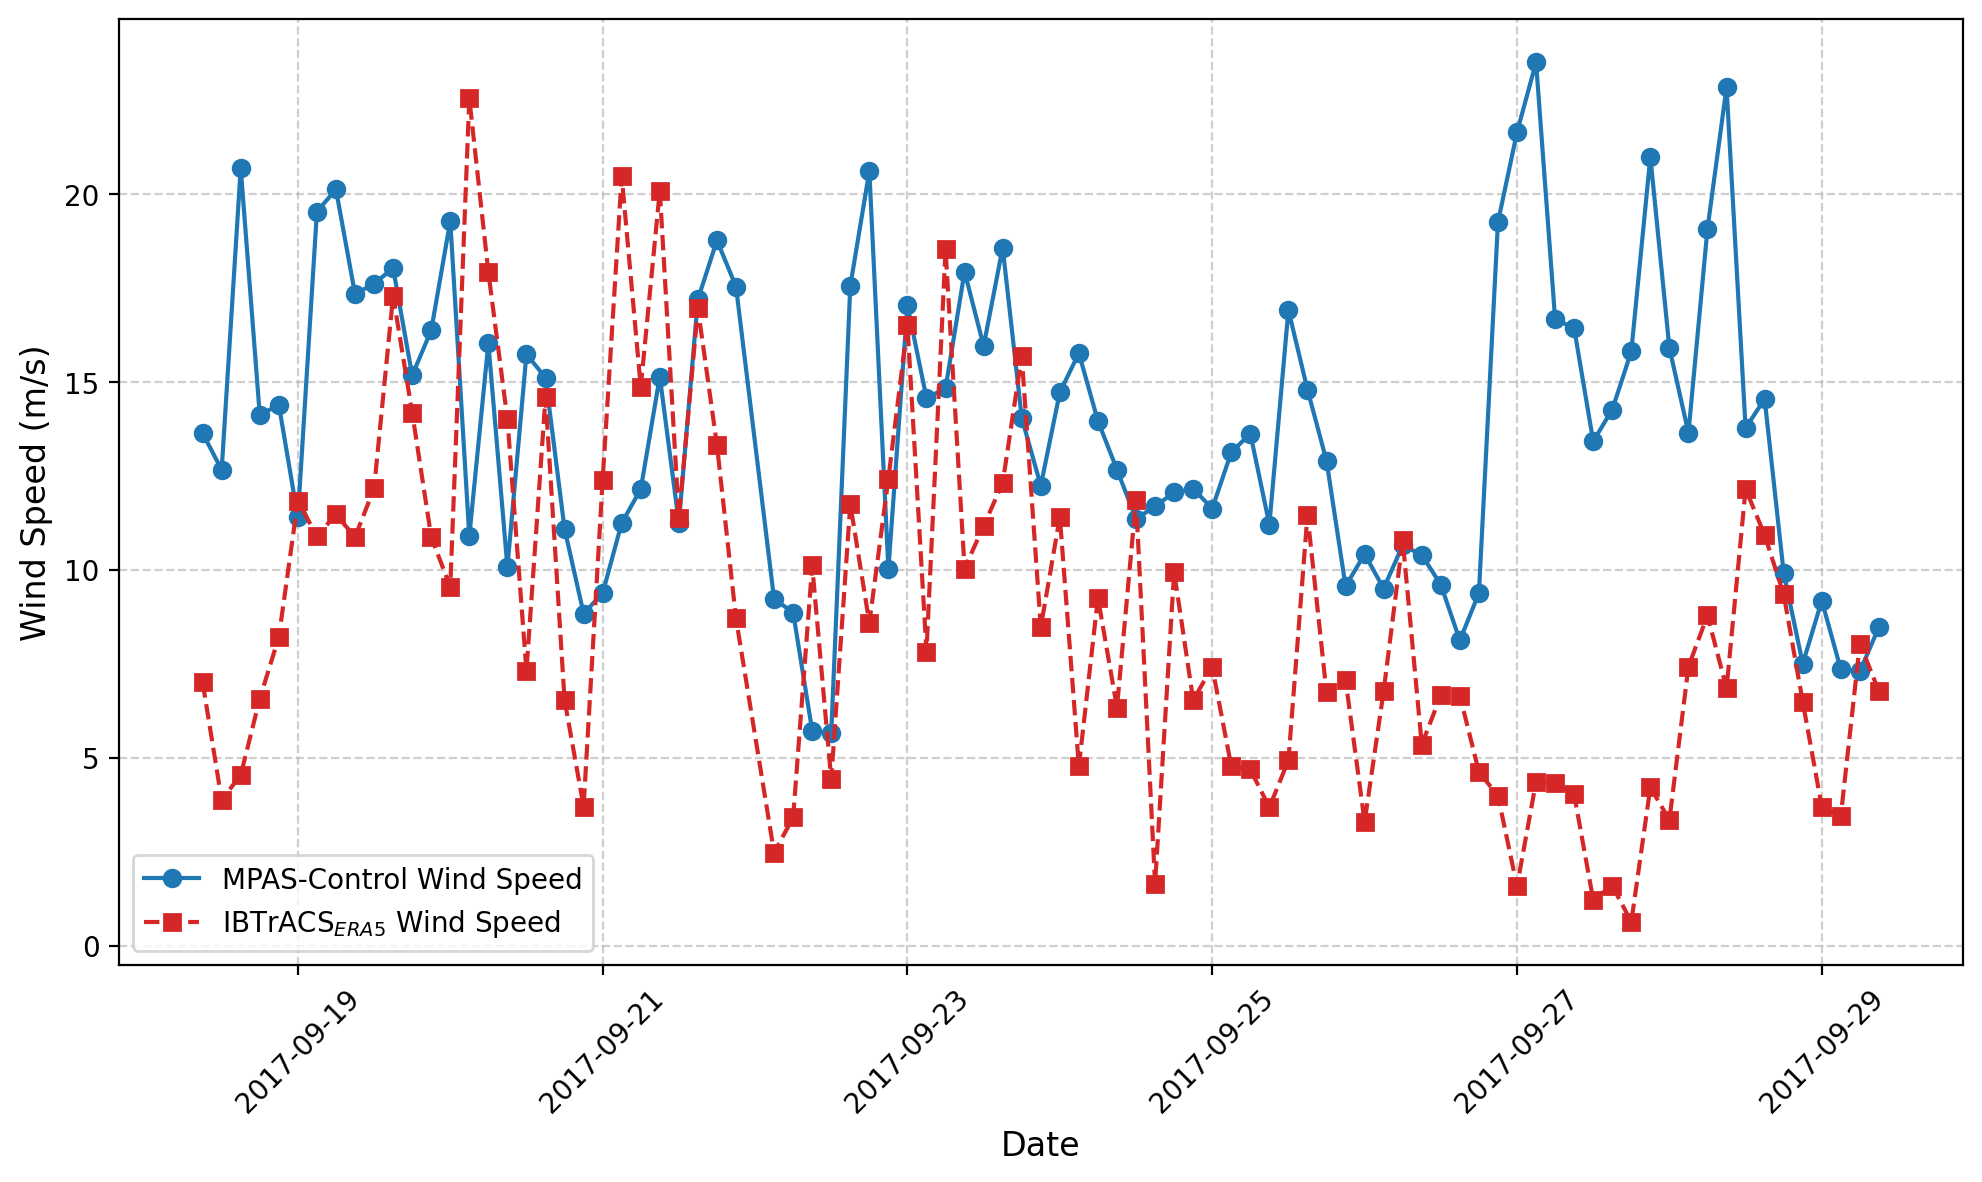

In [16]:
times = np.array(Maria_time_ibtracs)[_intersection_index]
plt.figure(figsize=(10, 6))

# Plot both datasets with clear labels and styles
plt.plot(times, mpas_ctrl_ws, label='MPAS-Control Wind Speed', linestyle='-', marker='o', color='tab:blue')
plt.plot(times, ibtracs_ws, label='IBTrACS$_{ERA5}$ Wind Speed', linestyle='--', marker='s', color='tab:red')

# Add labels and title
plt.xlabel('Date', fontsize=12)
plt.ylabel('Wind Speed (m/s)', fontsize=12)
# plt.title('Wind Speed Comparison: MPAS-Control vs IBTrACS$_{ERA5}$', fontsize=14)

# Show legend and grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('../Images/Wind_speed_ib_ctrl.png',dpi=350)

plt.show()

### HAVERSINE FORMULATION 
We use the Haversine Formula to compute the distance between points:

Here is a link to help understand what it is: https://en.wikipedia.org/wiki/Haversine_formula

In [16]:
import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance (in kilometers) between two points
    on the Earth given their latitude and longitude using the Haversine formula.
    """
    # Radius of Earth in kilometers
    R = 6371.0

    # Convert degrees to radians
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)

    # Differences
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))

    distance = R * c
    return distance




### Compute $\Delta distance$ and $\Delta windspeed$

In [17]:
### Delta Distance 


# List to store distances (in km) between consecutive IBTrACS storm track points
ibtracs_dist_diffs = []

# Loop through each pair of consecutive IBTrACS points
for ix in range(0, len(intersect_mpas) - 1):
    # Extract the current and next longitude and latitude for IBTrACS
    _x1, _y1 = x_ibtracs[ix], y_ibtracs[ix]
    _x2, _y2 = x_ibtracs[ix + 1], y_ibtracs[ix + 1]

    # Compute the distance using the haversine formula and store it
    ibtracs_dist_diffs.append(
        haversine_distance(_x1, _y1, _x2, _y2)
    )

# List to store distances (in km) between consecutive MPAS-CTRL storm track points
mpas_ctrl_dist_diffs = []

# Loop through each pair of consecutive MPAS-CTRL points
for ix in range(0, len(intersect_mpas) - 1):
    # Extract the current and next longitude and latitude for MPAS-CTRL
    _x1, _y1 = x_mpas_ctrl[ix], y_mpas_ctrl[ix]
    _x2, _y2 = x_mpas_ctrl[ix + 1], y_mpas_ctrl[ix + 1]

    # Compute the distance using the haversine formula and store it
    mpas_ctrl_dist_diffs.append(
        haversine_distance(_x1, _y1, _x2, _y2)
    )


In [18]:
### Delta Windspeed 


# List to store distances (in km) between consecutive IBTrACS storm track points
ibtracs_ws_diffs = []

# Loop through each pair of consecutive IBTrACS points windspeed
for ix in range(0, len(intersect_mpas) - 1):
    # Extract the current and next longitude and latitude for MPAS-CTRL
    _ws1, _ws2 = mpas_ctrl_ws[ix], mpas_ctrl_ws[ix+1]


    # Compute the distance using the haversine formula and store it
    ibtracs_ws_diffs.append(_ws2-_ws1)

# List to store distances (in km) between consecutive MPAS-CTRL storm track points
mpas_ctrl_ws_diffs = []

# Loop through each pair of consecutive MPAS-CTRL points windspeed
for ix in range(0, len(intersect_mpas) - 1):
    # Extract the current and next longitude and latitude for MPAS-CTRL
    _ws1, _ws2 = mpas_ctrl_ws[ix], mpas_ctrl_ws[ix+1]


    # Compute the distance using the haversine formula and store it
    mpas_ctrl_ws_diffs.append(_ws2-_ws1)


In [19]:
## STORM SPEED 
hr_2_s = 60*60
hrs = 3
mpas_ctrl_ss = np.array(mpas_ctrl_dist_diffs)/hrs
ibtracs_ss = np.array(ibtracs_dist_diffs)/hrs

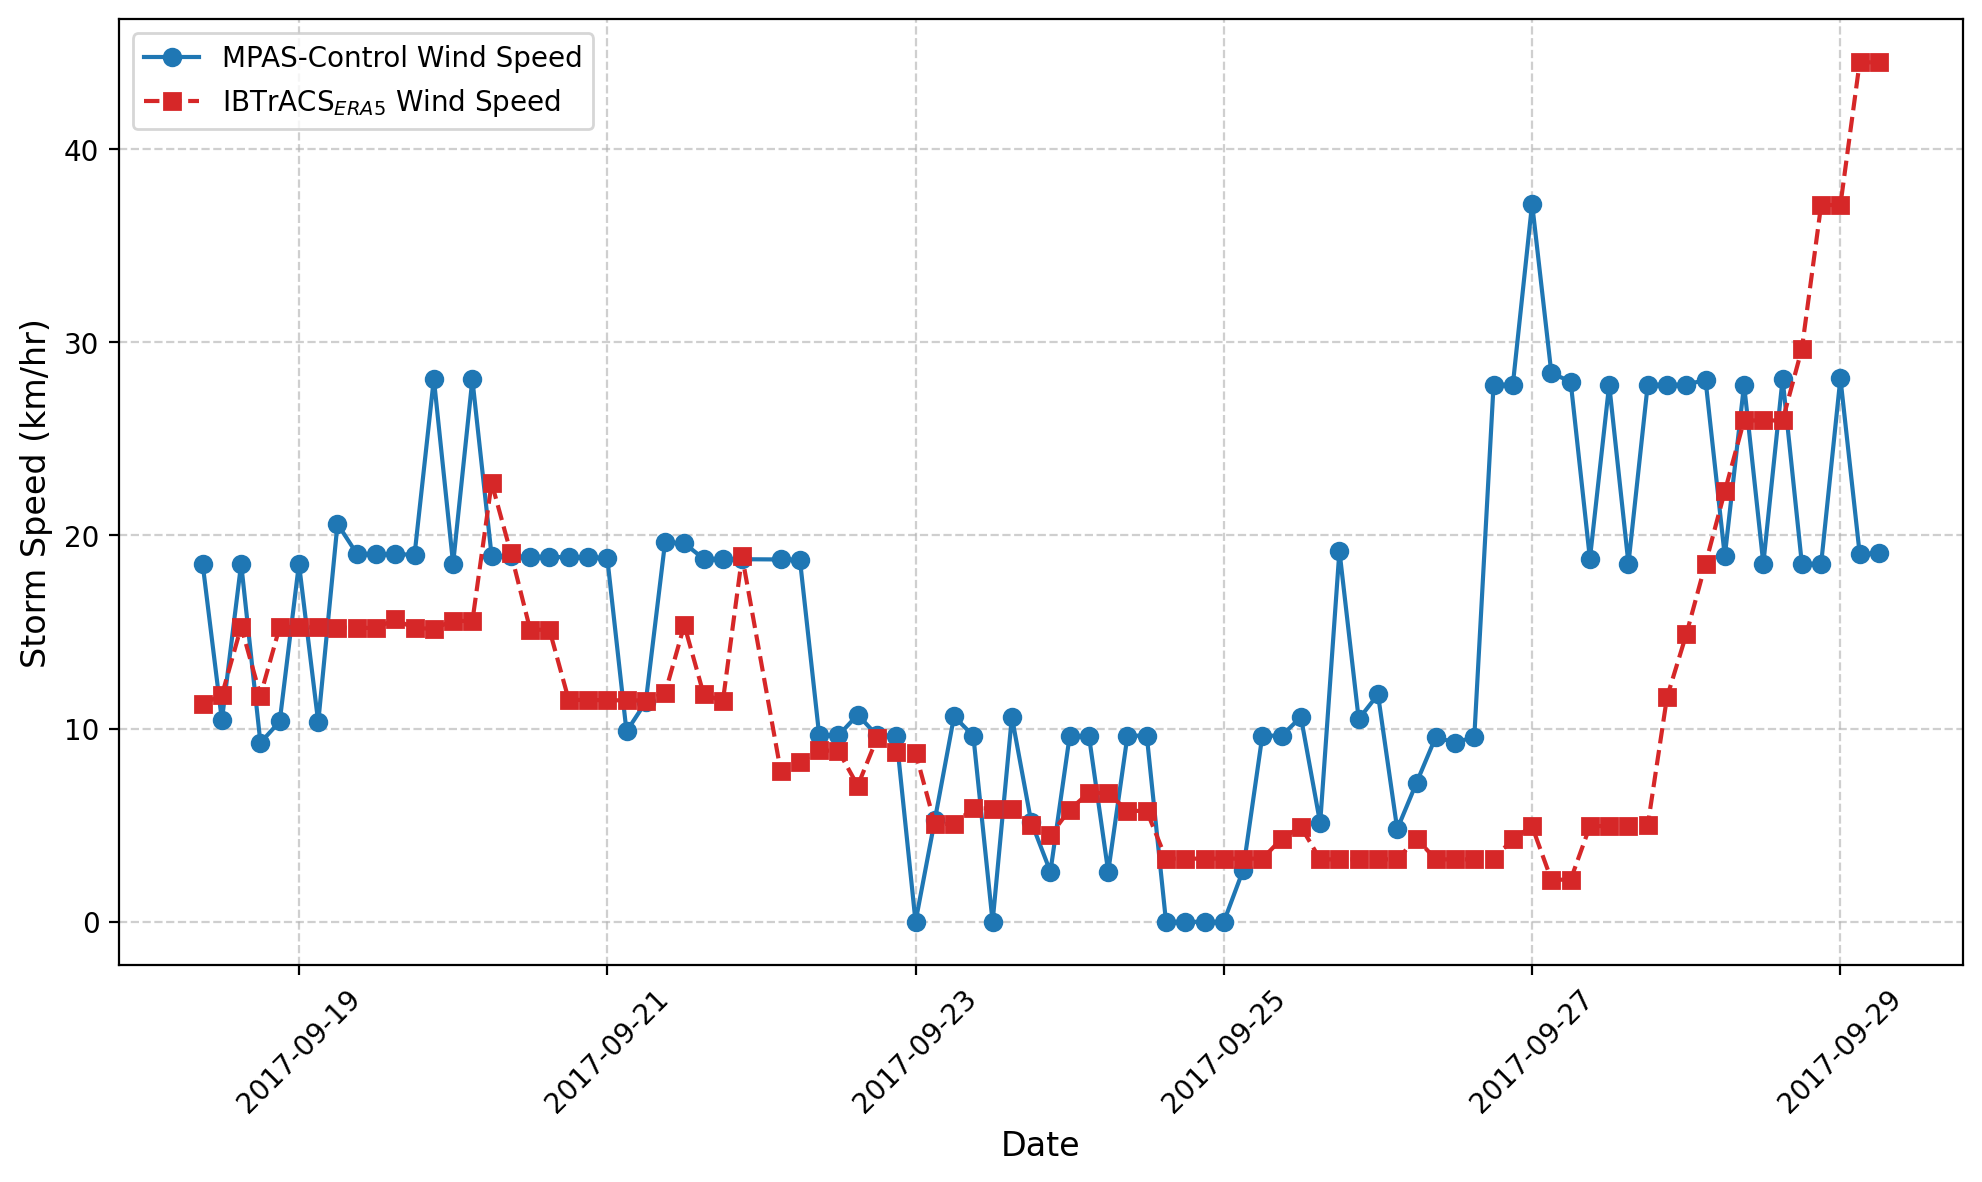

In [21]:
times = np.array(Maria_time_ibtracs)[_intersection_index][:-1]
plt.figure(figsize=(10, 6))

# Plot both datasets with clear labels and styles
plt.plot(times, mpas_ctrl_ss, label='MPAS-Control Wind Speed', linestyle='-', marker='o', color='tab:blue')
plt.plot(times, ibtracs_ss, label='IBTrACS$_{ERA5}$ Wind Speed', linestyle='--', marker='s', color='tab:red')

# Add labels and title
plt.xlabel('Date', fontsize=12)
plt.ylabel('Storm Speed (km/hr)', fontsize=12)
# plt.title('Storm Speed Comparison: MPAS-Control vs IBTrACS$_{ERA5}$', fontsize=14)

# Show legend and grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('../Images/Storm_speed_ib_ctrl.png',dpi=350)
plt.show()

### MAKE PGW PLOTS 

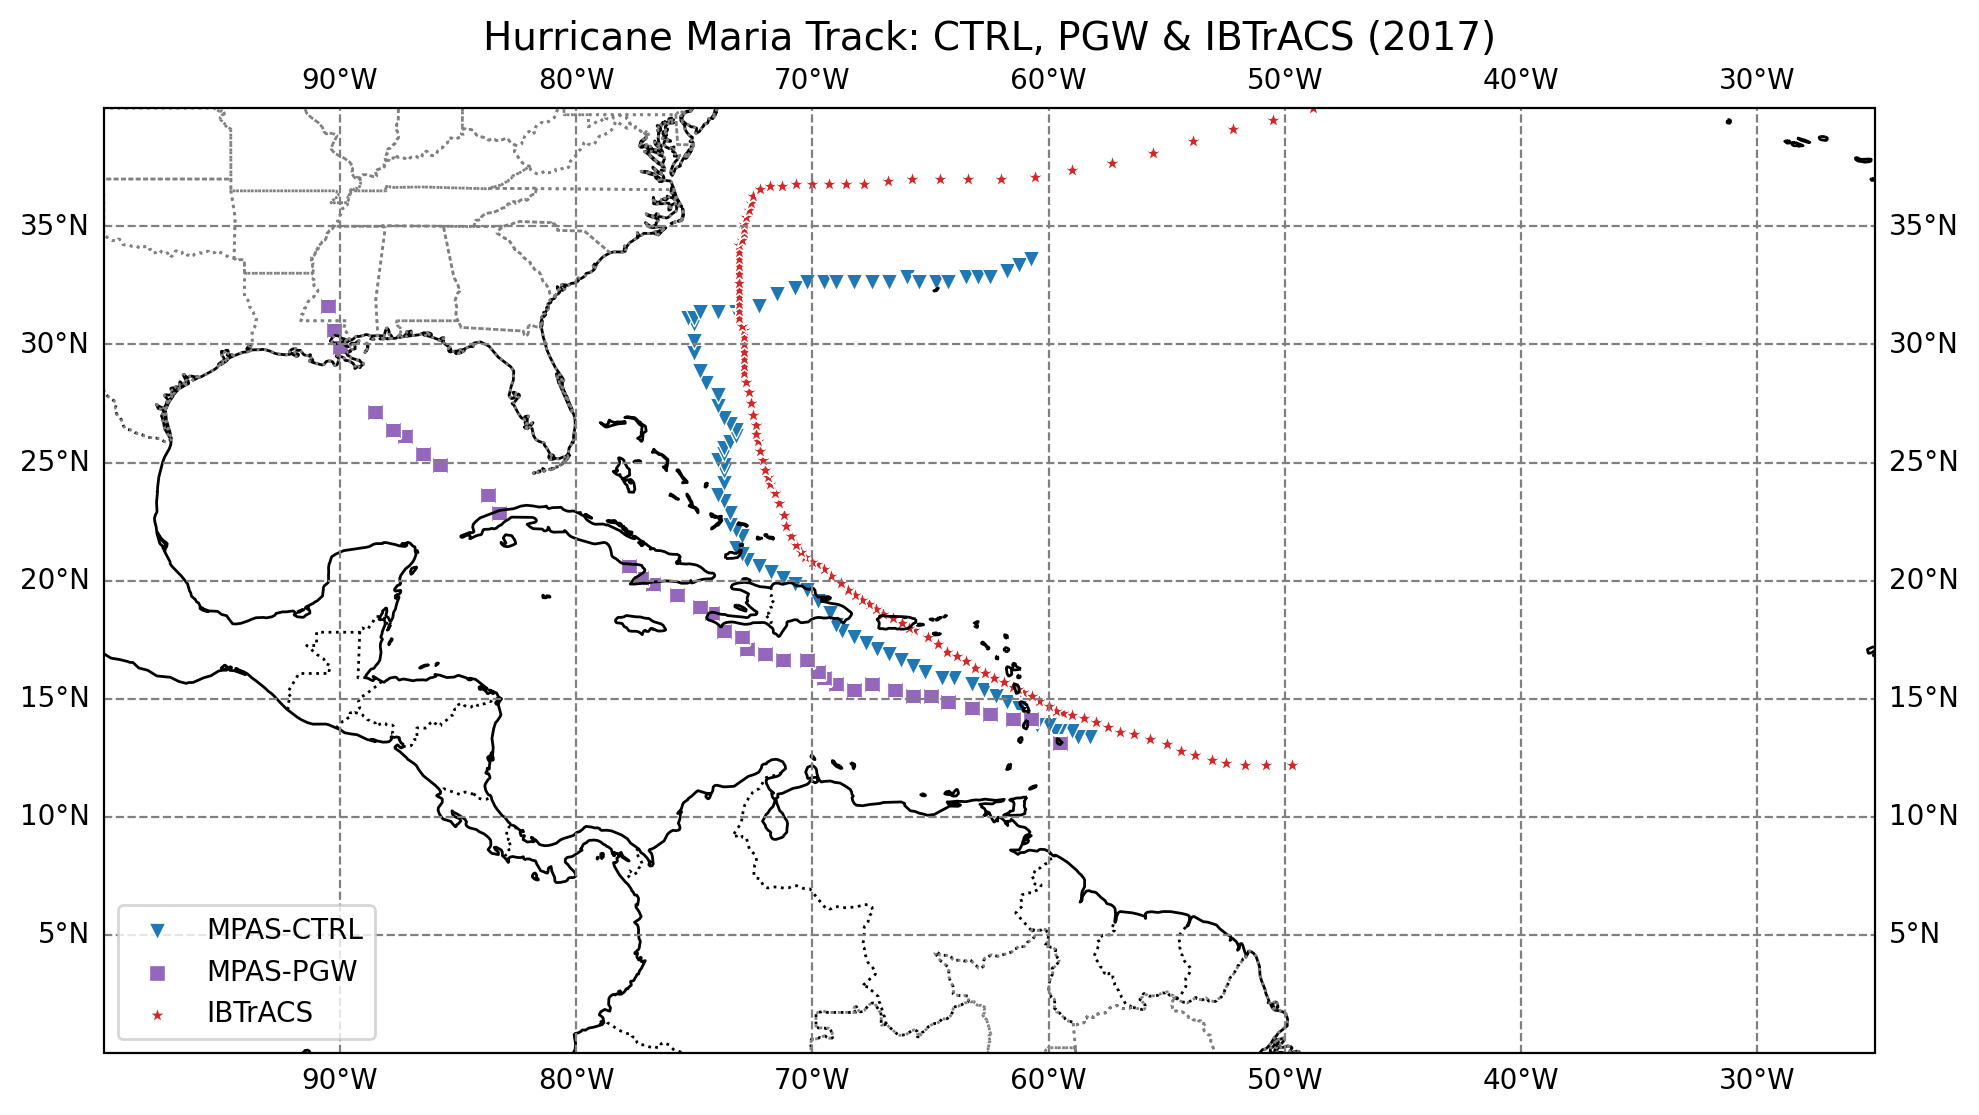

In [92]:
import matplotlib.pyplot as plt
import seaborn as sb
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set up the figure and axis with a PlateCarree projection for geographic plotting
fig, axes = plt.subplots(
    ncols=1, 
    nrows=1,
    figsize=(10, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Labels and markers for legend
labels = ['MPAS-CTRL', 'MPAS-PGW', 'IBTrACS']
mks = ['v', 's','*']  # Marker styles

# Plot MPAS-Maria (model) and IBTrACS-Maria (observation) for one selected track
for cx, ct in enumerate([3]):
    # Extract longitude and latitude for the MPAS-Maria track
    xvals = _store_tracks[f'track_{ct}'][:, 2]
    yvals = _store_tracks[f'track_{ct}'][:, 3]

    # Plot MPAS-Maria track
    sb.scatterplot(
        ax=axes, 
        x=xvals,
        y=yvals,
        marker=mks[0],
        label=labels[0],
        color='tab:blue'
    )

    # Extract longitude and latitude for the MPAS-PGW-Maria track
    xvals = _store_pgw_tracks[f'track_{ct}'][:, 2]
    yvals = _store_pgw_tracks[f'track_{ct}'][:, 3]
    
    # Plot MPAS-PGW-Maria track
    sb.scatterplot(
        ax=axes, 
        x=xvals,
        y=yvals,
        marker=mks[1],
        label=labels[1],
        color='tab:purple'
    )
    

    # Plot IBTrACS-Maria track
    sb.scatterplot(
        ax=axes, 
        x=maria_df['lon'], 
        y=maria_df['lat'],
        marker=mks[2],
        label=labels[2],
        color='tab:red'
    )

    # Customize the map view using Cartopy
    axes.set_extent([-100, -25, 0, 40], crs=ccrs.PlateCarree())  # [llon, rlon, blat, tlat]

    # Add geographical features for context
    axes.add_feature(cfeature.COASTLINE)
    axes.add_feature(cfeature.BORDERS, linestyle=':')
    axes.add_feature(cfeature.STATES, linestyle=':', edgecolor='gray')
    axes.gridlines(draw_labels=True, linestyle='--', color='gray')

    # Add title and legend
    axes.set_title('Hurricane Maria Track: CTRL, PGW & IBTrACS (2017)', fontsize=14)
    axes.legend(loc='lower left')

plt.tight_layout()
plt.savefig('../Images/Tracks_ib_ctrl.png',dpi=350)

plt.show()


In [20]:
## Obtain the lon-lats for MPAS and IBTrACS
x_mpas_ctrl = _store_tracks[f'track_{ct}'][:, 2]
y_mpas_ctrl = _store_tracks[f'track_{ct}'][:, 3]

x_mpas_pgw = _store_pgw_tracks[f'track_{ct}'][:, 2]
y_mpas_pgw = _store_pgw_tracks[f'track_{ct}'][:, 3]

x_ibtracs=np.array(maria_df['lon'])[_intersection_index]
y_ibtracs=np.array(maria_df['lat'])[_intersection_index]

In [21]:
rad = 0.25/2
ibtracs_ws = [era_ws.sel(time=t, latitude = slice(y+rad, y-rad)
                                , longitude=slice(x-rad,x+rad)).mean(['longitude','latitude']).values 
              for t,x,y in zip(intersect_mpas,x_ibtracs,y_ibtracs)]

In [22]:
rad = 0.25/2
mpas_ctrl_vars = [mpas_data.sel(time=t, lat = slice(y-rad, y+rad)
                                , lon=slice(x-rad,x+rad)).mean(['lon','lat']) 
                  for t,x,y in zip(intersect_mpas,x_mpas_ctrl,y_mpas_ctrl)]
mpas_ctrl_ws = [mpas_ctrl_vars[ix]['wind_speed10m'].values for ix in range(0,len(mpas_ctrl_vars))]

mpas_pgw_vars = [mpas_pgw_data.sel(time=t, lat = slice(y-rad, y+rad)
                                , lon=slice(x-rad,x+rad)).mean(['lon','lat']) 
                  for t,x,y in zip(MPAS_time_pgw,x_mpas_pgw,y_mpas_pgw)]
mpas_pgw_ws = [mpas_pgw_vars[ix]['wind_speed10m'].values for ix in range(0,len(mpas_pgw_vars))]

In [23]:

mpas_ctrl_msl = [mpas_ctrl_vars[ix]['msl'].values for ix in range(0,len(mpas_ctrl_vars))]

mpas_pgw_msl = [mpas_pgw_vars[ix]['msl'].values for ix in range(0,len(mpas_pgw_vars))]

In [24]:
rad = 0.25/2
ibtracs_msl = [era_msl['MSL'].sel(time=t, latitude = slice(y+rad, y-rad)
                                , longitude=slice(x-rad,x+rad)).mean(['longitude','latitude']).values 
              for t,x,y in zip(intersect_mpas,x_ibtracs,y_ibtracs)]

In [25]:
from scipy.stats import pearsonr

In [26]:
corr_eff = pearsonr(mpas_ctrl_msl,ibtracs_msl)
stdevs = np.std(np.array(mpas_ctrl_msl)-np.array(ibtracs_msl))

In [27]:
stdevs/100

13.550487060546875

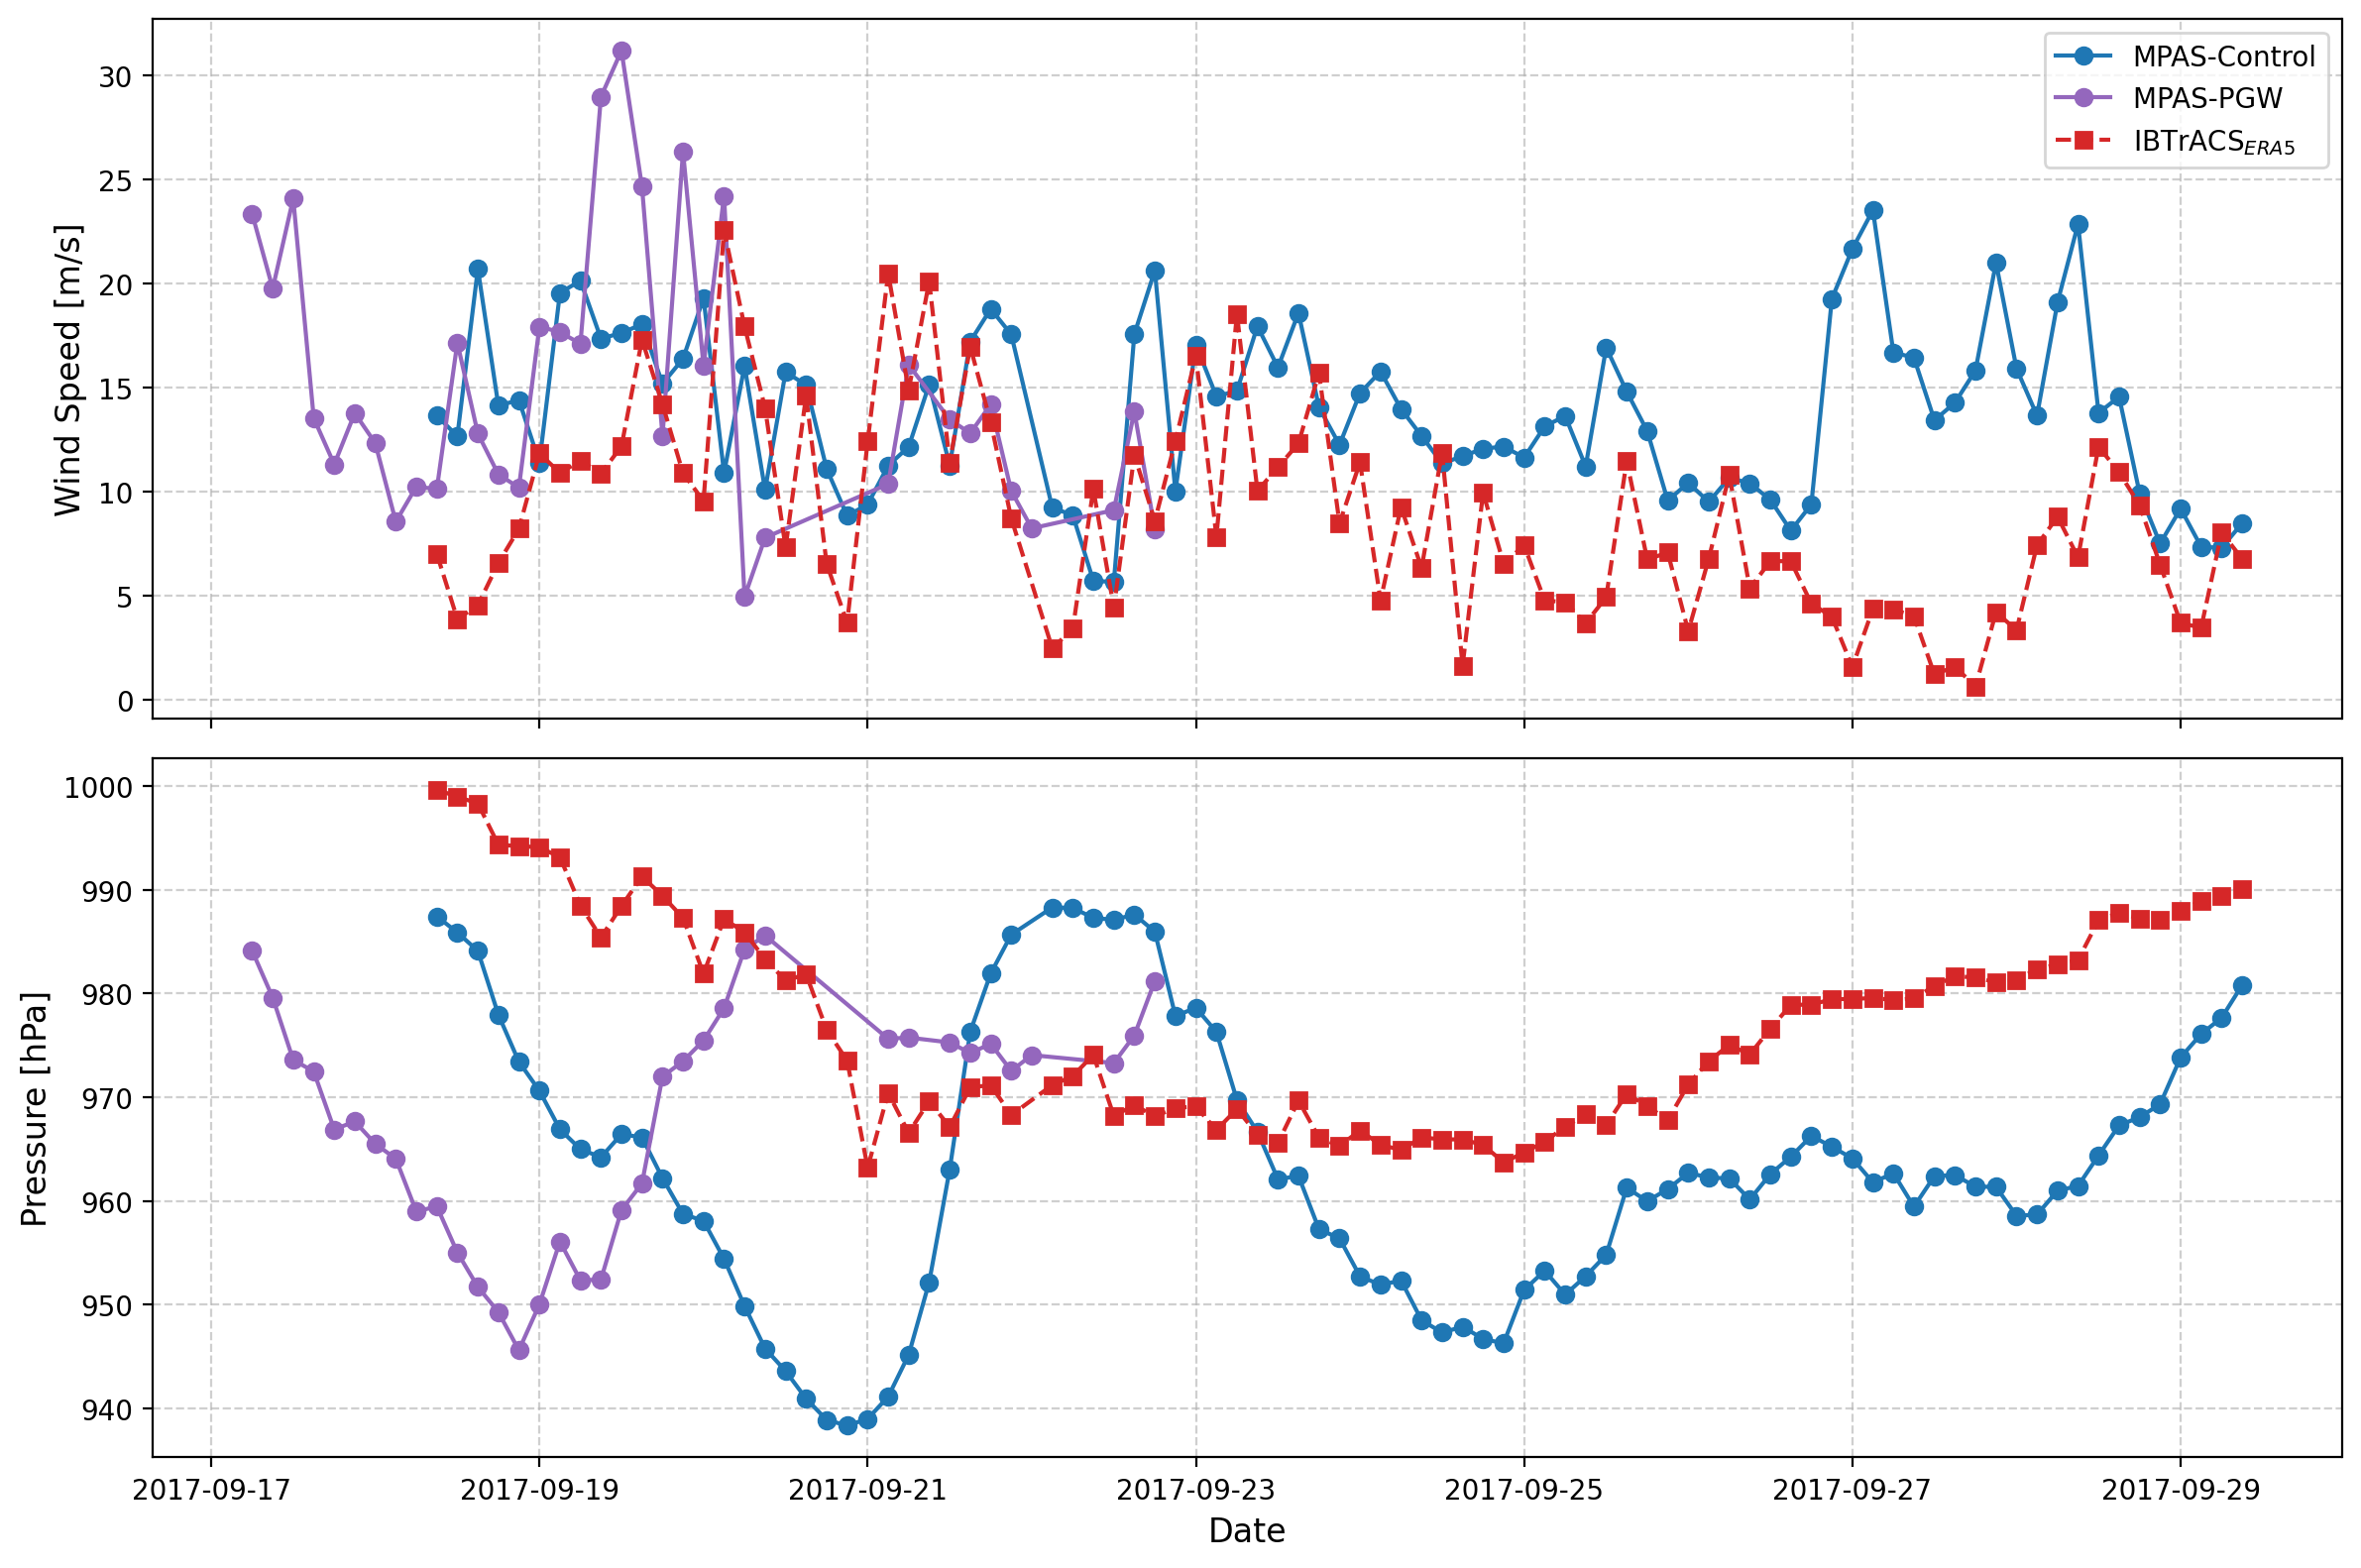

In [93]:
times = np.array(Maria_time_ibtracs)[_intersection_index]
# times_pgw = np.array(
fig,axes = plt.subplots(ncols=1,nrows=2, figsize=(12,8), sharex=True)
vbls = ['ws','msl']
lbls = ['MPAS-Control','MPAS-PGW ', 'IBTrACS$_{ERA5}$']
ylabs = ['Wind Speed [m/s]', 'Pressure [hPa]']
for ax,(vx,vbs) in zip(axes.flat, enumerate(vbls)):
    
    # Plot both datasets with clear labels and styles
    if vbs == 'msl':
        _ctrl = np.divide(eval(f'mpas_ctrl_{vbs}'),100 ) #hPa
        _pgw = np.divide(eval(f'mpas_pgw_{vbs}'),100 ) #hPa
        _ibtracs = np.divide(eval(f'ibtracs_{vbs}'),100 ) #hPa
    else:
        _ctrl = eval(f'mpas_ctrl_{vbs}') 
        _pgw = eval(f'mpas_pgw_{vbs}')
        _ibtracs = eval(f'ibtracs_{vbs}')

    # CONTROL
    ax.plot(times,_ctrl, label=lbls[0], linestyle='-', marker='o', color='tab:blue')

    #PGW
    ax.plot(MPAS_time_pgw, _pgw, label=lbls[1], linestyle='-', marker='o', color='tab:purple')
    
    #IBTrACS
    ax.plot(times, _ibtracs, label=lbls[2], linestyle='--', marker='s', color='tab:red')
    
    # Add labels and title
    ax.set_xlabel('Date', fontsize=12) if vx == 1 else ax.set_xlabel('', fontsize=12)
    ax.set_ylabel(ylabs[vx], fontsize=12)
    # plt.title('Wind Speed Comparison: MPAS-Control vs IBTrACS$_{ERA5}$', fontsize=14)
    
    # Show legend and grid
    if vx == 0:
        ax.legend() 
    ax.grid(True, linestyle='--', alpha=0.6)
    # ax.set_xticks(rotation=45)
    plt.tight_layout()
# plt.savefig('../Images/winds_msl_ib_ctrl_pgw_cats.png',dpi=350)
    
plt.show()

### Make Plots of Categories of Hurricanes

In [34]:
def ms_to_knots(speed_ms):
    return speed_ms * 2.23694#1.94384

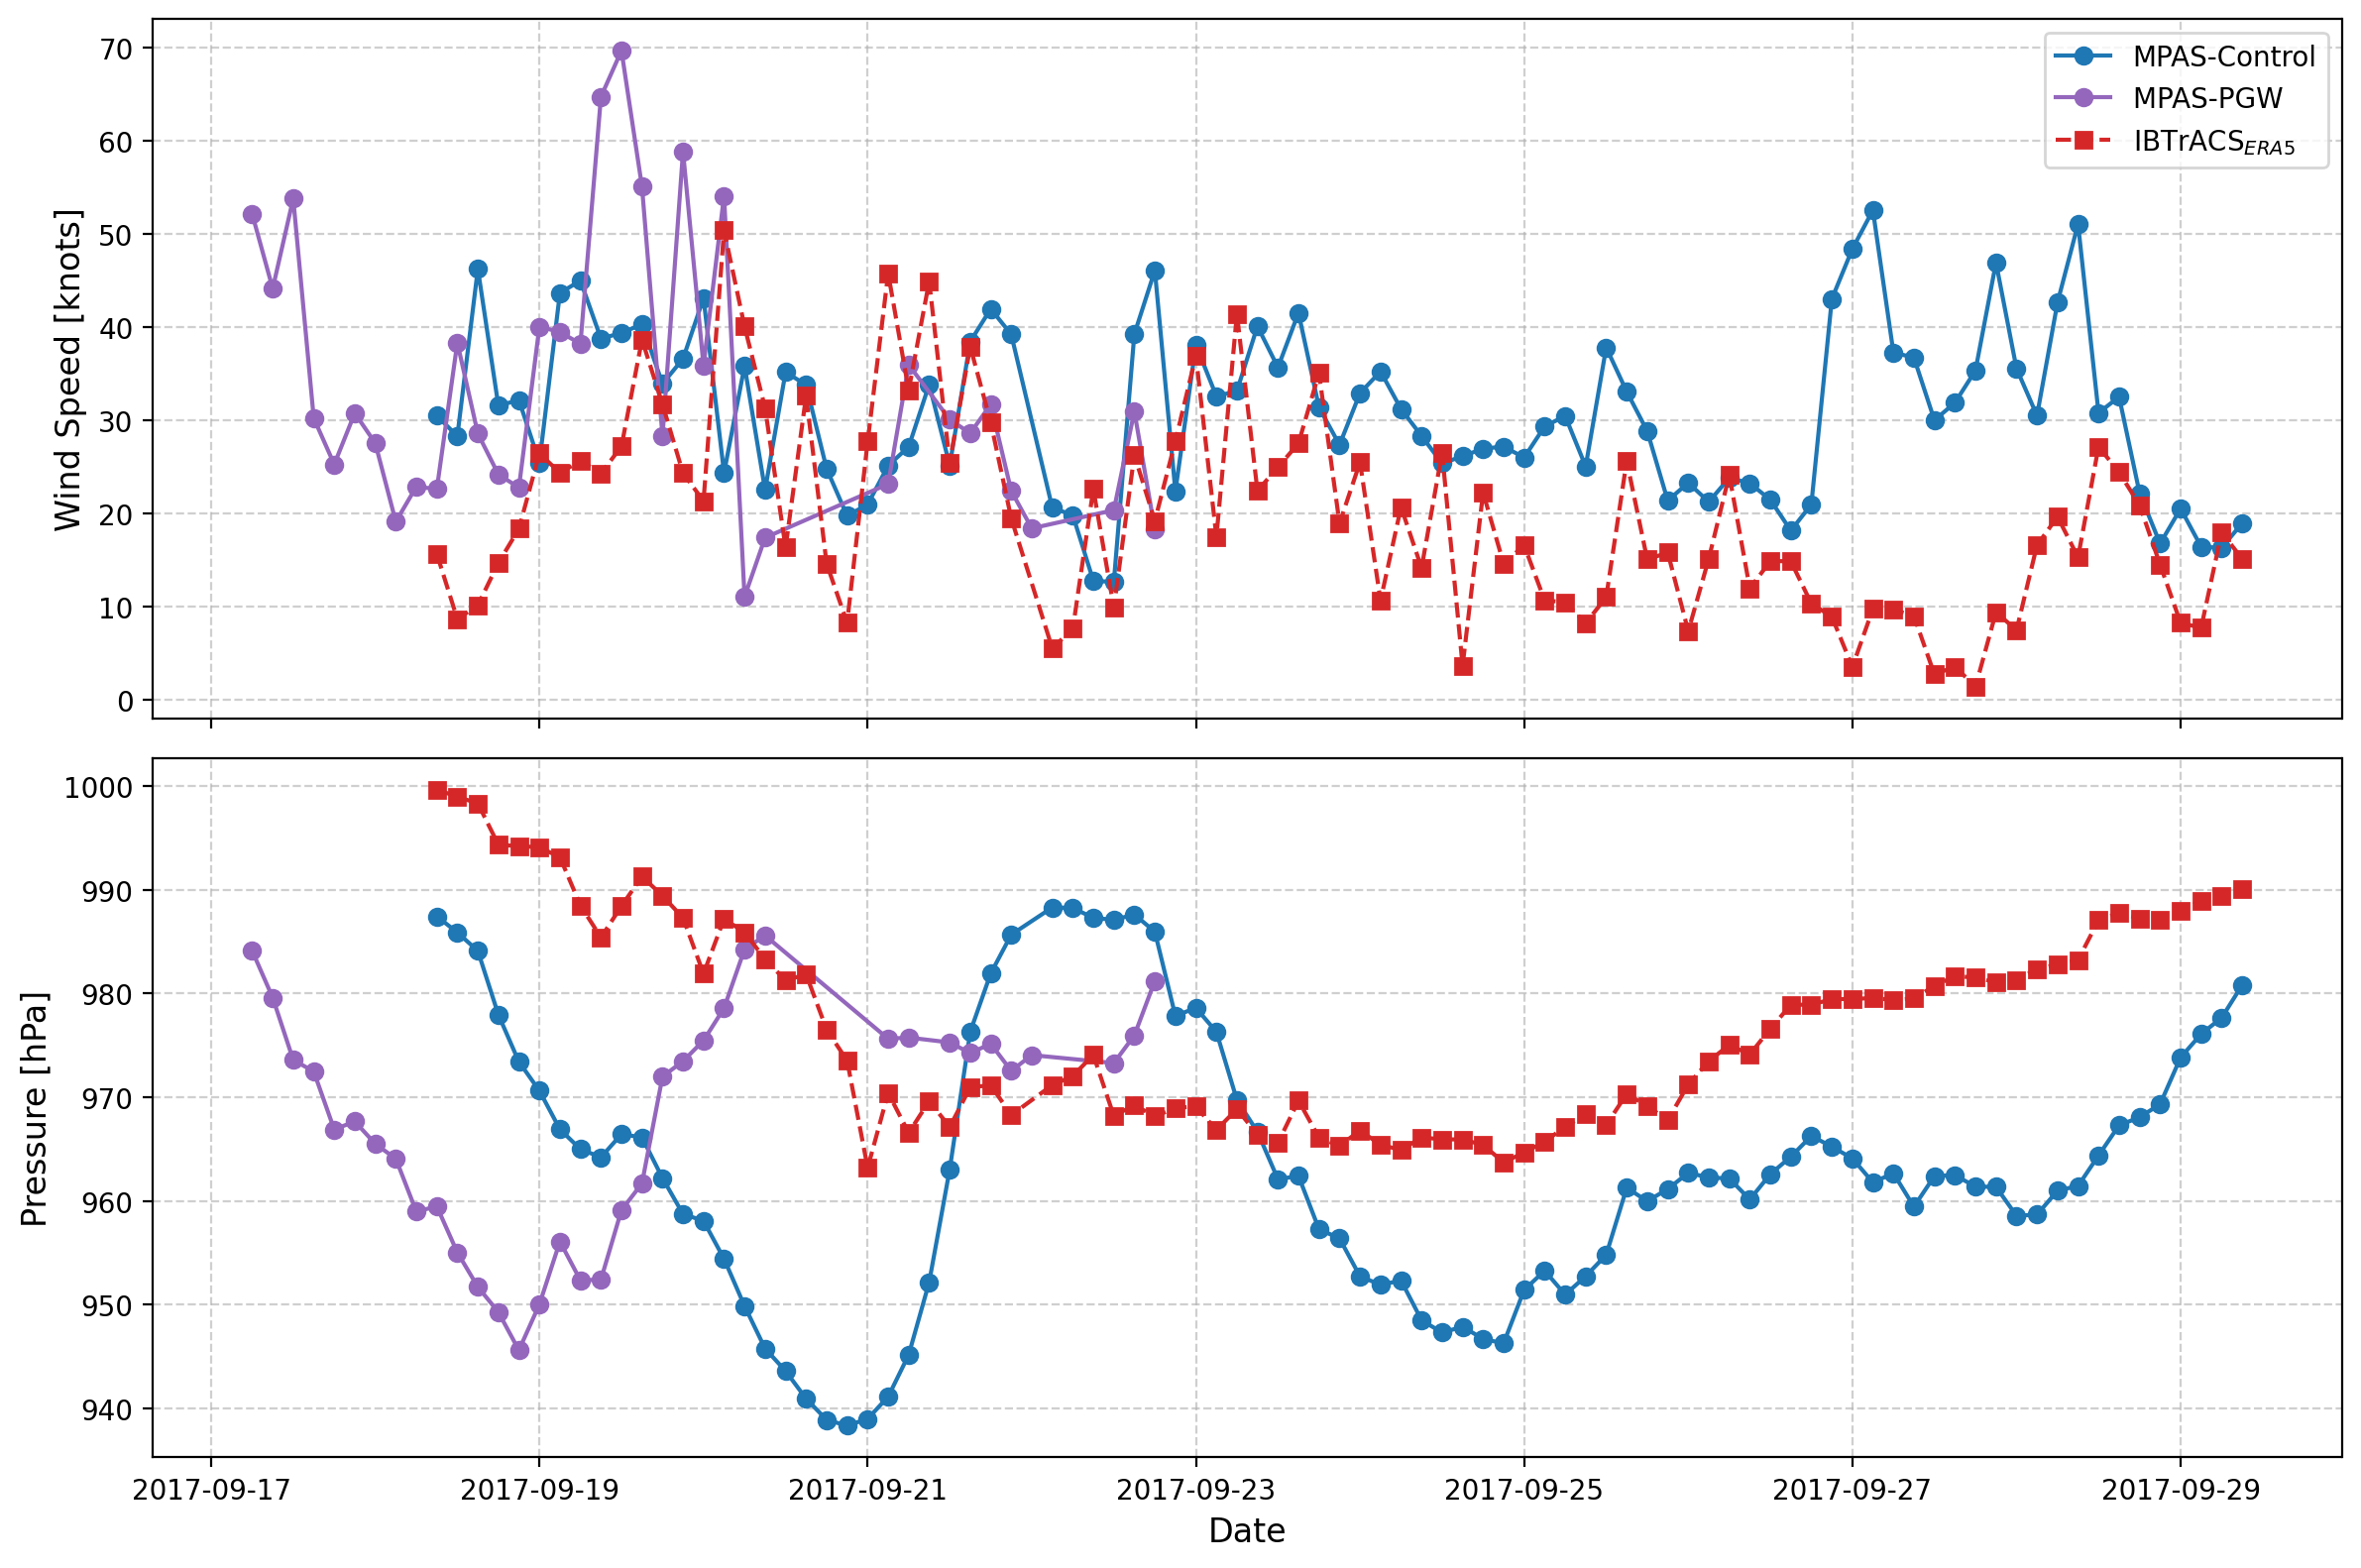

In [35]:
times = np.array(Maria_time_ibtracs)[_intersection_index]
# times_pgw = np.array(
fig,axes = plt.subplots(ncols=1,nrows=2, figsize=(12,8), sharex=True)
vbls = ['ws','msl']
lbls = ['MPAS-Control','MPAS-PGW ', 'IBTrACS$_{ERA5}$']
ylabs = ['Wind Speed [knots]', 'Pressure [hPa]']
for ax,(vx,vbs) in zip(axes.flat, enumerate(vbls)):
    
    # Plot both datasets with clear labels and styles
    if vbs == 'msl':
        _ctrl = np.divide(eval(f'mpas_ctrl_{vbs}'),100 ) #hPa
        _pgw = np.divide(eval(f'mpas_pgw_{vbs}'),100 ) #hPa
        _ibtracs = np.divide(eval(f'ibtracs_{vbs}'),100 ) #hPa
    else:
        _ctrl = ms_to_knots(np.array(eval(f'mpas_ctrl_{vbs}') ))
        _pgw = ms_to_knots(np.array(eval(f'mpas_pgw_{vbs}')))
        _ibtracs = ms_to_knots(np.array(eval(f'ibtracs_{vbs}')))

    # CONTROL
    ax.plot(times,_ctrl, label=lbls[0], linestyle='-', marker='o', color='tab:blue')

    #PGW
    ax.plot(MPAS_time_pgw, _pgw, label=lbls[1], linestyle='-', marker='o', color='tab:purple')
    
    #IBTrACS
    ax.plot(times, _ibtracs, label=lbls[2], linestyle='--', marker='s', color='tab:red')
    
    # Add labels and title
    ax.set_xlabel('Date', fontsize=12) if vx == 1 else ax.set_xlabel('', fontsize=12)
    ax.set_ylabel(ylabs[vx], fontsize=12)
    # plt.title('Wind Speed Comparison: MPAS-Control vs IBTrACS$_{ERA5}$', fontsize=14)
    
    # Show legend and grid
    if vx == 0:
        ax.legend() 
    ax.grid(True, linestyle='--', alpha=0.6)
    # ax.set_xticks(rotation=45)
    plt.tight_layout()
# plt.savefig('../Images/winds_msl_ib_ctrl_pgw_cats.png',dpi=350)
    
plt.show()

In [32]:
ms_to_knots(np.array(eval(f'mpas_ctrl_{vbs}')))

array([26.50977 , 24.607063, 40.220516, 27.445173, 27.979431, 22.153791,
       37.96871 , 39.120502, 33.70566 , 34.240353, 35.04495 , 29.494518,
       31.826824, 37.480846, 21.176584, 31.162727, 19.572208, 30.592413,
       29.380144, 21.560036, 17.178333, 18.226727, 21.859718, 23.609213,
       29.431581, 21.876623, 33.430573, 36.481945, 34.093266, 17.927986,
       17.227974, 11.116933, 10.987368, 34.122772, 40.068428, 19.467625,
       33.124508, 28.328169, 28.822643, 34.864   , 31.016928, 36.110893,
       27.298307, 23.791336, 28.62002 , 30.646832, 27.138302, 24.622839,
       22.065815, 22.730768, 23.439137, 23.63389 , 22.608608, 25.516554,
       26.489319, 21.777737, 32.880085, 28.762808, 25.081604, 18.587746,
       20.253534, 18.468857, 20.714817, 20.204893, 18.67073 , 15.786617,
       18.234423, 37.41524 , 42.079422, 45.69329 , 32.411972, 31.9349  ,
       26.089634, 27.7277  , 30.736345, 40.80343 , 30.916565, 26.521025,
       37.087124, 44.39995 , 26.767307, 28.281694, 

### DIFFERENT DATE FORMAT 
import matplotlib.dates as mdates

# Shared settings
vbls = ['ws', 'msl']
lbls = ['MPAS-Control', 'MPAS-PGW', 'IBTrACS$_{ERA5}$']
ylabs = ['Wind Speed [m/s]', 'Pressure [hPa]']
colors = ['tab:blue', 'tab:purple', 'tab:red']

times_ctrl = np.array(Maria_time_ibtracs)[_intersection_index]
times_pgw = MPAS_time_pgw  # Already defined

fig, axes = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

for vx, (vbs, ax) in enumerate(zip(vbls, axes)):

    # Convert msl from Pa → hPa
    if vbs == 'msl':
        _ctrl = np.divide(eval(f'mpas_ctrl_{vbs}'), 100)
        _pgw = np.divide(eval(f'mpas_pgw_{vbs}'), 100)
        _ibtracs = np.divide(eval(f'ibtracs_{vbs}'), 100)
    else:
        _ctrl = eval(f'mpas_ctrl_{vbs}')
        _pgw = eval(f'mpas_pgw_{vbs}')
        _ibtracs = eval(f'ibtracs_{vbs}')

    # MPAS-Control
    ax.plot(times_ctrl, _ctrl, label=lbls[0], linestyle='-', marker='o', color=colors[0])

    # MPAS-PGW
    ax.plot(times_pgw, _pgw, label=lbls[1], linestyle='-', marker='o', color=colors[1])

    # IBTrACS
    ax.plot(times_ctrl, _ibtracs, label=lbls[2], linestyle='--', marker='s', color=colors[2])

    # Labels
    ax.set_ylabel(ylabs[vx], fontsize=12)

    # Legend only on top panel
    if vx == 0:
        ax.legend(loc='best')

    ax.grid(True, linestyle='--', alpha=0.6)

# Shared x-axis formatting
axes[-1].set_xlabel('Date', fontsize=12)
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('../Images/winds_msl_ib_ctrl_pgw.png', dpi=350)
plt.show()


## INTERESTING THINGS ABOUT THE PLOTS 

- CTRL can simulate the storm speed and propagation speed
- CTRL does not do well with the track path. It deviates from the original path by about 300km
- CTRL can show the MSLP dips and rises, but does deviate with ~13hPa standard deviation

## INTERESTING THINGS ABOUT PGW
- PGW simulations undergo a rapid intensification within 24hrs. It spikes from 10m/s to 32m/s around 18th to 19th Sept.

## INTERESTING THINGS ABOUT IBTrACS
- The storm intensifies (gradual reduction of surface pressure) and reduces intensity (increase in surface pressure).
- On 22nd, the storm is at weakest MSLP, but reintensifies as it propagates. 


## TO-DO

- Create plots of along track
  * Divide the track into 3 parts, look at the path from SE to NW, then SSE to NNW, and then, SW to NE
  * Compare the vertical velocities under MPAS vs PGW

- Things to calculate
  * MSE and Moist Enthalpy
  * Equivalent potential temperature

In [43]:
# Save path for frames
sv_path = "../Images/msl_gif"
os.makedirs(sv_path, exist_ok=True)

# Extract times from dataset
used_times = vv.time.values

# Fix color range to avoid flickering between frames
vmin = float(vv.msl.min())/100
vmax = float(vv.msl.max())/100

for ix, t in enumerate(used_times):
    # Create figure with a map projection
    fig, ax = plt.subplots(
        ncols=1, figsize=(6, 5),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Plot MSL for current time step
    ((vv.msl)/100).isel(time=ix).plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='viridis',
        vmin=vmin, vmax=vmax,
        cbar_kwargs={'label': 'Mean Sea Level Pressure (hPa)'}
    )

    # Add map features
    ax.coastlines()
    ax.set_title(f"MSL - {str(t)[:16]}", fontsize=12)

    # Save frame with zero-padded index
    plt.tight_layout()
    plt.savefig(f"{sv_path}/frame_{ix:03d}.png", dpi=150)
    plt.close()


In [44]:
import imageio

# Path where frames were saved
frame_paths = sorted(glob.glob(f"{sv_path}/frame_*.png"))

# Create GIF
gif_path = "../Images/msl_animation.gif"
with imageio.get_writer(gif_path, mode='I', duration=0.3) as writer:  # duration=0.3 sec per frame
    for frame in frame_paths:
        image = imageio.imread(frame)
        writer.append_data(image)

print(f"GIF saved at {gif_path}")


/glade/derecho/scratch/ktquagra/tmp/ipykernel_45362/2413816004.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


GIF saved at ../Images/msl_animation.gif
